In [1]:
%pip install --quiet --upgrade jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget

/home/flapkap/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Deploy AI and data apps for free on Ploomber Cloud! Sign up here: https://www.platform.ploomber.io/register


In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./389963.duckdb

Connecting to 'duckdb:///./389963.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
hej = %sql select message from Trace WHERE message LIKE 'TIMINGS>%'

In [7]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 805 ms, Load: 41 ms, sensor init: 10 ms, env init: 0 ms, net init: 8427 ms, Collect: -1 ms, Exec: -1 ms, Send: 7363 ms, save config: 603 ms, Sleep: 6 s\n'

In [8]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,793642F96160FCDBE923812F1607F9E3,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [9]:

timestamps= %sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,281342,283642,140671.5,81216.5840546128,69894,140298,211249,281342,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,281342,0.0%
2,timestamp,TIMESTAMP,2024-01-17 13:07:04.112197,2024-01-17 13:12:09.881811,282517,None,None,None,None,None,281342,0.0%
3,current,FLOAT,-0.001563,0.134817,1455,0.05918071040936126,0.013626696630348297,0.05195963174790749,0.05280247248759342,0.05929566738653761,281342,0.0%
4,voltage,FLOAT,1.635,4.93,309,4.854831145678359,0.10941468505815351,4.857500076293945,4.858749866485596,4.860000133514404,281342,0.0%
5,power,FLOAT,0.0,0.653204,458,0.28758564156431354,0.06612068744769792,0.252734037729647,0.25655470993113716,0.2881857938493891,281342,0.0%


In [10]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,281342,2024-01-17 13:07:04.112197,2024-01-17 13:12:09.881811


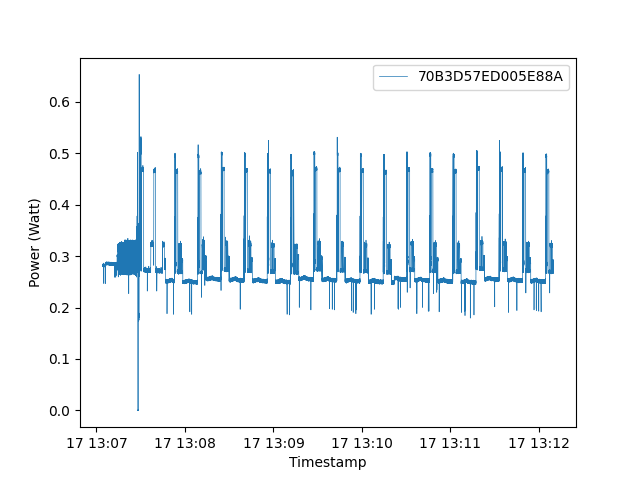

In [11]:
deveui = "70B3D57ED005EA56"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

In [12]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] =="70B3D57ED005E88A")]


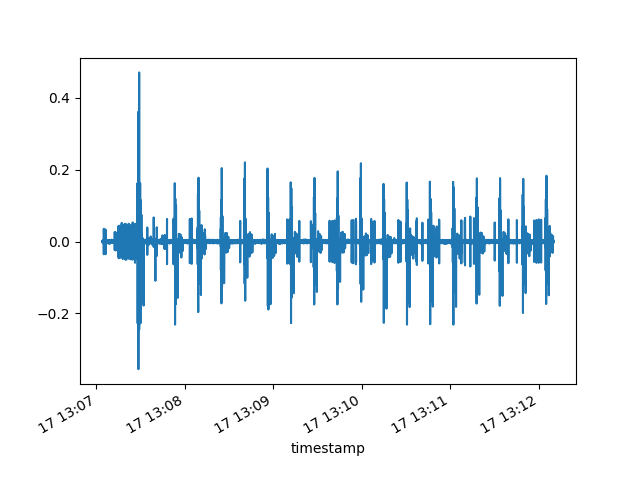

In [13]:
plt.figure()
power_diff.plot()
plt.show()

In [14]:
rising_edge = power_consumption[power_diff > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-01-17 13:07:27.715236,0.499366,0.102755,4.85750,70B3D57ED005E88A,0.161775,rising
2024-01-17 13:07:27.915194,0.273491,0.056285,4.86000,70B3D57ED005E88A,-0.227706,falling
2024-01-17 13:07:27.977168,0.072036,0.015799,3.76875,70B3D57ED005E88A,-0.200234,falling
2024-01-17 13:07:28.415136,0.363841,0.085710,4.36125,70B3D57ED005E88A,0.361399,rising
2024-01-17 13:07:28.416204,0.008547,0.001685,4.86500,70B3D57ED005E88A,-0.355294,falling


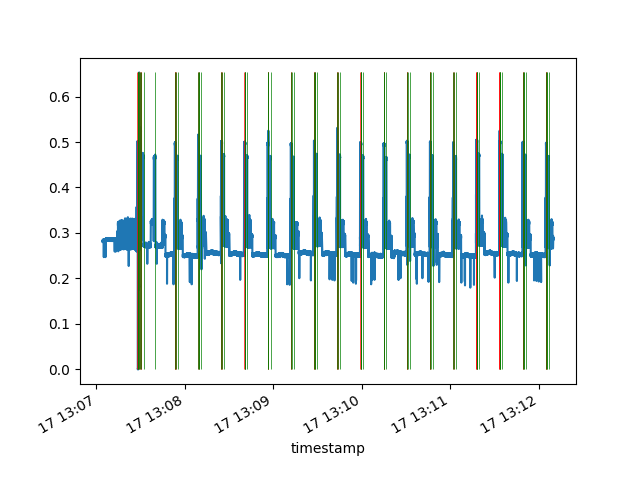

In [15]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [16]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2024-01-17 13:07:27.715236,0.499366,0.102755,4.85750,70B3D57ED005E88A,0.161775,rising,falling,2024-01-17 13:07:27.915194
2024-01-17 13:07:29.610615,0.504249,0.103878,4.85375,70B3D57ED005E88A,0.162385,rising,falling,2024-01-17 13:07:29.810574
2024-01-17 13:07:30.013797,0.503639,0.103682,4.85750,70B3D57ED005E88A,0.110495,rising,falling,2024-01-17 13:07:30.213786
2024-01-17 13:07:53.080277,0.496924,0.102413,4.85625,70B3D57ED005E88A,0.162386,rising,falling,2024-01-17 13:07:53.280235
2024-01-17 13:07:53.483489,0.496924,0.102291,4.85625,70B3D57ED005E88A,0.108664,rising,falling,2024-01-17 13:07:53.683448


In [17]:
## add counter to sync signals and add sync signal start and end times
edges.loc[:,'sync_num'] = range(len(edges)) 
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-01-17 13:07:27.715236,0.499366,0.102755,4.85750,70B3D57ED005E88A,0.161775,rising,falling,2024-01-17 13:07:27.915194,0,2024-01-17 13:07:27.615236,2024-01-17 13:07:28.015194
2024-01-17 13:07:29.610615,0.504249,0.103878,4.85375,70B3D57ED005E88A,0.162385,rising,falling,2024-01-17 13:07:29.810574,1,2024-01-17 13:07:29.510615,2024-01-17 13:07:29.910574
2024-01-17 13:07:30.013797,0.503639,0.103682,4.85750,70B3D57ED005E88A,0.110495,rising,falling,2024-01-17 13:07:30.213786,2,2024-01-17 13:07:29.913797,2024-01-17 13:07:30.313786
2024-01-17 13:07:53.080277,0.496924,0.102413,4.85625,70B3D57ED005E88A,0.162386,rising,falling,2024-01-17 13:07:53.280235,3,2024-01-17 13:07:52.980277,2024-01-17 13:07:53.380235
2024-01-17 13:07:53.483489,0.496924,0.102291,4.85625,70B3D57ED005E88A,0.108664,rising,falling,2024-01-17 13:07:53.683448,4,2024-01-17 13:07:53.383489,2024-01-17 13:07:53.783448


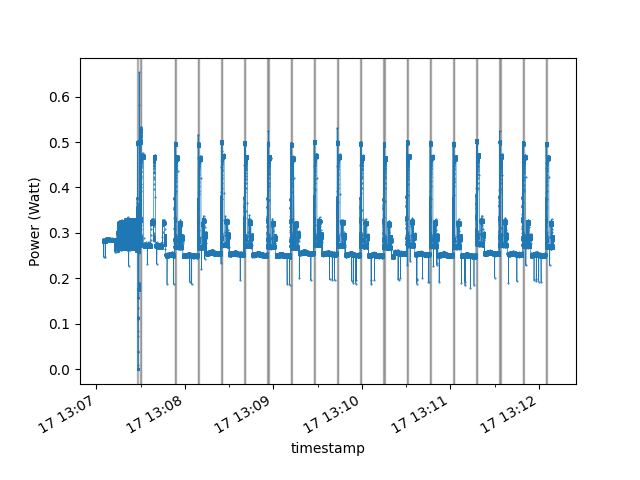

In [18]:
# visually verify sync signals
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in edges.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5, label="sync signal")

plt.gca().xaxis.set_major_locator(dates.AutoDateLocator())
plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))
plt.show()

In [19]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
edges['next_sync_start'] = edges['sync_start'].shift(-1)
edges['next_sync_end'] = edges['sync_end'].shift(-1)
loops = edges[(abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500))][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_start', 'next_sync_end': 'loop_end'}, inplace=True)
loops['loop_num'] = range(len(loops))
loops.head()

,node_id,loop_start,loop_end,loop_num
timestamp,,,,
2024-01-17 13:07:29.610615,70B3D57ED005E88A,2024-01-17 13:07:29.510615,2024-01-17 13:07:30.313786,0
2024-01-17 13:07:53.080277,70B3D57ED005E88A,2024-01-17 13:07:52.980277,2024-01-17 13:07:53.783448,1
2024-01-17 13:08:08.808678,70B3D57ED005E88A,2024-01-17 13:08:08.708678,2024-01-17 13:08:09.510781,2
2024-01-17 13:08:24.537141,70B3D57ED005E88A,2024-01-17 13:08:24.437141,2024-01-17 13:08:25.239213,3
2024-01-17 13:08:40.264505,70B3D57ED005E88A,2024-01-17 13:08:40.164505,2024-01-17 13:08:40.967706,4


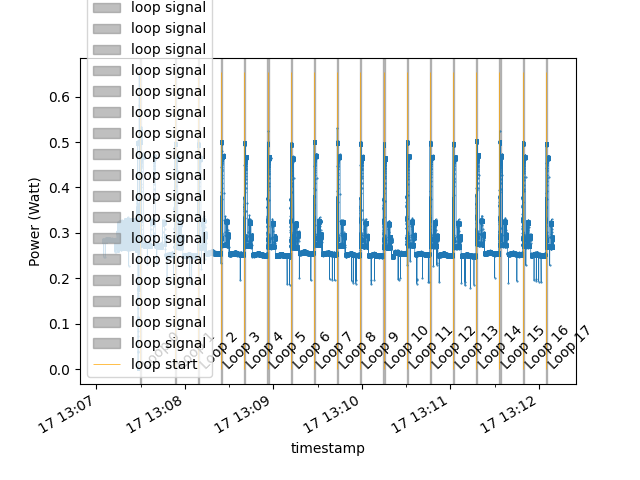

In [20]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in loops.itertuples():
    plt.axvspan(row.loop_start, row.loop_end, color='grey', alpha=0.5, label="loop signal")
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")

plt.legend()
plt.gca().xaxis.set_major_locator(dates.AutoDateLocator())
plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))
plt.show()

In [21]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings.head()

,node_id,timestamp,loop_num,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
0,70B3D57ED005E88A,2024-01-17 14:07:46.793682,0,805,41,10,0,8427,-1,-1,7363,603,6
1,70B3D57ED005E88A,2024-01-17 14:07:58.521715,1,806,74,10,0,56,-1,-1,4028,532,10
2,70B3D57ED005E88A,2024-01-17 14:08:14.249881,2,806,74,10,0,56,-1,-1,4028,533,10
3,70B3D57ED005E88A,2024-01-17 14:08:29.977777,3,806,74,10,0,56,-1,-1,4028,533,10
4,70B3D57ED005E88A,2024-01-17 14:08:45.706047,4,806,74,10,0,56,-1,-1,4028,532,10


In [22]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_start')
loops.head()

,timestamp_x,node_id,loop_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_start,,,,,,,,,,,,,,,
2024-01-17 13:07:29.510615,2024-01-17 13:07:29.610615,70B3D57ED005E88A,2024-01-17 13:07:30.313786,0,2024-01-17 14:07:46.793682,805,41,10,0,8427,-1,-1,7363,603,6
2024-01-17 13:07:52.980277,2024-01-17 13:07:53.080277,70B3D57ED005E88A,2024-01-17 13:07:53.783448,1,2024-01-17 14:07:58.521715,806,74,10,0,56,-1,-1,4028,532,10
2024-01-17 13:08:08.708678,2024-01-17 13:08:08.808678,70B3D57ED005E88A,2024-01-17 13:08:09.510781,2,2024-01-17 14:08:14.249881,806,74,10,0,56,-1,-1,4028,533,10
2024-01-17 13:08:24.437141,2024-01-17 13:08:24.537141,70B3D57ED005E88A,2024-01-17 13:08:25.239213,3,2024-01-17 14:08:29.977777,806,74,10,0,56,-1,-1,4028,533,10
2024-01-17 13:08:40.164505,2024-01-17 13:08:40.264505,70B3D57ED005E88A,2024-01-17 13:08:40.967706,4,2024-01-17 14:08:45.706047,806,74,10,0,56,-1,-1,4028,532,10


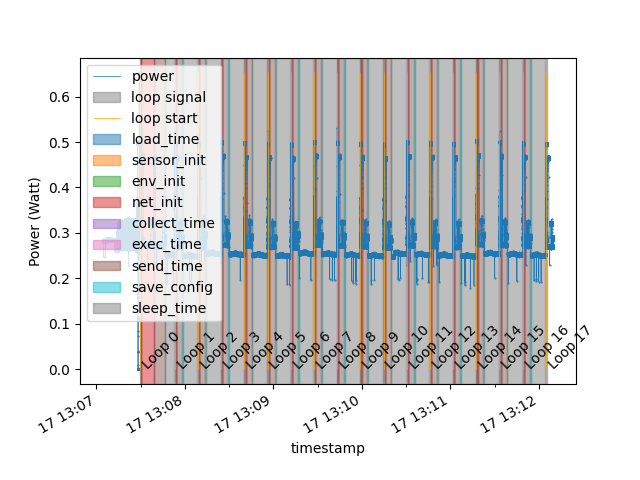

In [23]:
for row in loops.itertuples():
    start_time = row.Index
    sync_start = start_time
    sync_end = sync_start + pd.Timedelta(milliseconds=row.sync_time_ms)
    load_start = sync_end
    load_end = load_start + pd.Timedelta(milliseconds=row.load_time_ms)
    sensor_init_start = load_end
    sensor_init_end = sensor_init_start + pd.Timedelta(milliseconds=row.sensor_init_time_ms)
    env_init_start = sensor_init_end
    env_init_end = env_init_start + pd.Timedelta(milliseconds=row.env_init_time_ms)
    net_init_start = env_init_end
    net_init_end = net_init_start + pd.Timedelta(milliseconds=row.net_init_time_ms)
    collect_time_start = net_init_end
    collect_time_end = collect_time_start + pd.Timedelta(milliseconds=row.collect_time_ms)
    exec_start = collect_time_end
    exec_end = exec_start + pd.Timedelta(milliseconds=row.exec_time_ms)
    send_start = exec_end
    send_end = send_start + pd.Timedelta(milliseconds=row.send_time_ms)
    save_config_start = send_end
    save_config_end = save_config_start + pd.Timedelta(milliseconds=row.save_config_time_ms)
    sleep_start = save_config_end
    sleep_end = sleep_start + pd.Timedelta(seconds=row.sleep_time_s)
    plt.axvspan(load_start, load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(sensor_init_start, sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(env_init_start, env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(net_init_start, net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(collect_time_start, collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(exec_start, exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(send_start, send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(save_config_start, save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(sleep_start, sleep_end, color='tab:grey', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [24]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

,trace_id,node_id,timestamp,message


In [25]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

NameError: name 'send_frame_end' is not defined

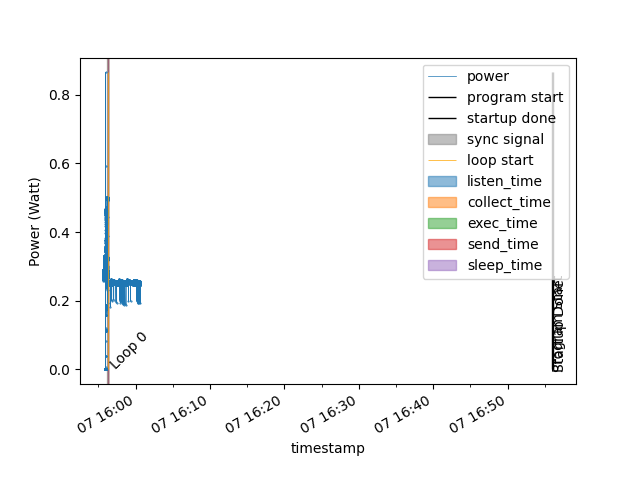

In [ ]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

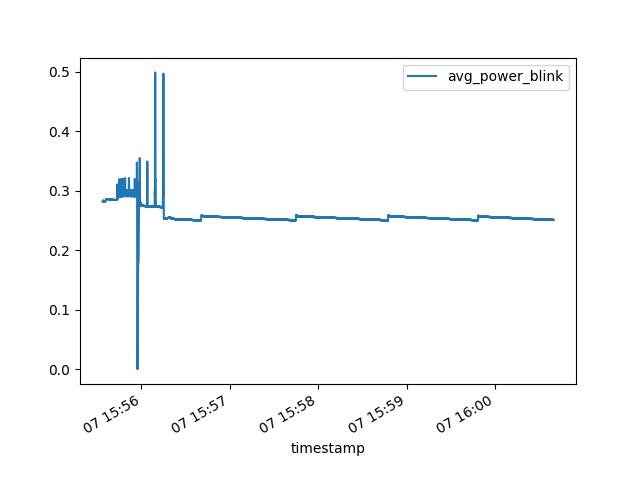

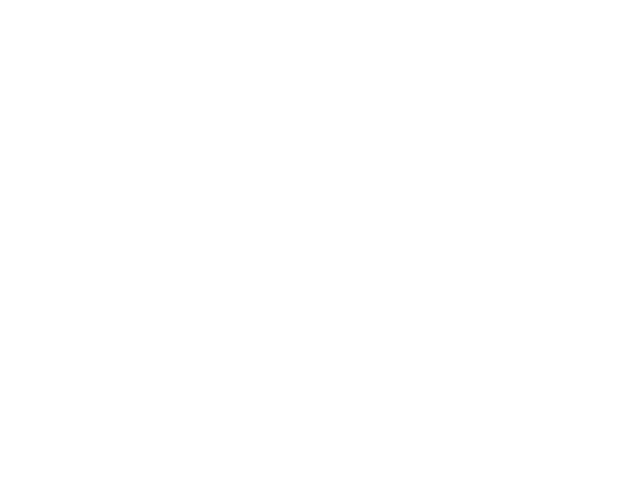

In [ ]:
plt.figure()
res.plot(x='timestamp')
plt.show()

In [ ]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

NameError: name 'filtered_power_diff' is not defined

In [ ]:
%sql select count(*) from Trace

,count_star()
0,607


In [ ]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [ ]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [ ]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'